In [10]:
from power_calculator import calculate_power
import os
import pandas as pd
from scrape_cardlists import DATA_PATH
BASE_PWR_PATH = os.path.join(DATA_PATH, "decks", "baseline")
MANUAL_SAVE = os.path.join(DATA_PATH, "decks", "manual_rand")
GPT_SAVE = os.path.join(DATA_PATH, "completed")
DECKS = os.path.join(DATA_PATH, "decks")

In [11]:
import os
import ast
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compile_power(directory):
    data = []  # To hold dictionaries from files
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.basename(root)  # Get the current folder name
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                #print(file_path)
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                    if lines:
                        try:
                            # Convert the last line to a dictionary
                            last_line_dict = ast.literal_eval(lines[-1].strip())
                            # Ensure it's actually a dictionary
                            if isinstance(last_line_dict, dict):
                                last_line_dict['folder'] = folder_name  # Add folder name to the dictionary
                                last_line_dict['commander'] = file
                                data.append(last_line_dict)
                        except (ValueError, SyntaxError):
                            print(f"Error processing file: {file_path}")
                            continue
    return pd.DataFrame(data)

# Replace 'path_to_your_directory' with the actual path to your directory
directory_path = 'path_to_your_directory'

df = compile_power(DECKS)
for col in df:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

df.head()

Error processing file: /Users/linus/Documents/2024_Q2_WINTER/dsc180b/edh-llm/data/decks/gpt/RakkaMar.txt


,overall,cmc,ramp,draw,interaction,folder,commander
0,4,3.074627,6,7,10,manual_rand,SaryththeVipersFang.txt
1,6,3.441176,3,9,8,manual_rand,PhenaxGodofDeception.txt
2,6,2.955882,7,16,12,manual_rand,JennyGeneratedAnomaly.txt
3,5,3.340000,9,7,15,manual_rand,PiaNalaar.txt
4,4,3.074627,9,10,5,manual_rand,IntiSeneschaloftheSun.txt


In [12]:
df.to_pickle("../data/power.pkl")

In [13]:
df[df['cmc'] > 5]

,overall,cmc,ramp,draw,interaction,folder,commander


In [14]:
df.groupby('folder').count()

,overall,cmc,ramp,draw,interaction,commander
folder,,,,,,
baseline,189,189,189,189,189,189
edh,189,189,189,189,189,189
gpt,188,188,188,188,188,188
manual_rand,189,189,189,189,189,189


In [15]:
df.groupby('folder').median()

/var/folders/sj/q2c4jzkd1gs0fdhj3lyp4z_40000gn/T/ipykernel_8349/4183382856.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('folder').median()


,overall,cmc,ramp,draw,interaction
folder,,,,,
baseline,2.0,3.454545,1.0,6.0,4.0
edh,7.0,2.555556,11.0,11.0,8.0
gpt,5.0,3.343590,6.0,11.0,10.0
manual_rand,4.0,3.328358,4.0,10.0,8.0


In [16]:
df.groupby('folder').mean()

/var/folders/sj/q2c4jzkd1gs0fdhj3lyp4z_40000gn/T/ipykernel_8349/920149010.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('folder').mean()


,overall,cmc,ramp,draw,interaction
folder,,,,,
baseline,2.645503,3.437020,3.994709,10.222222,7.222222
edh,6.851852,2.600532,12.052910,11.656085,8.206349
gpt,5.356383,3.312369,7.154255,12.058511,10.122340
manual_rand,4.433862,3.311894,5.259259,11.407407,8.883598


In [30]:
df

,overall,cmc,ramp,draw,interaction,folder,commander
0,4,3.074627,6,7,10,manual_rand,SaryththeVipersFang.txt
1,6,3.441176,3,9,8,manual_rand,PhenaxGodofDeception.txt
2,6,2.955882,7,16,12,manual_rand,JennyGeneratedAnomaly.txt
3,5,3.340000,9,7,15,manual_rand,PiaNalaar.txt
4,4,3.074627,9,10,5,manual_rand,IntiSeneschaloftheSun.txt
...,...,...,...,...,...,...,...
750,1,3.953846,1,2,1,baseline,AkromaVisionofIxidor.txt
751,2,3.746269,3,0,2,baseline,JasmineBorealoftheSeven.txt
752,2,3.969231,1,8,10,baseline,UyoSilentProphet.txt
753,2,4.409091,4,14,10,baseline,GandalfWestwardVoyager.txt


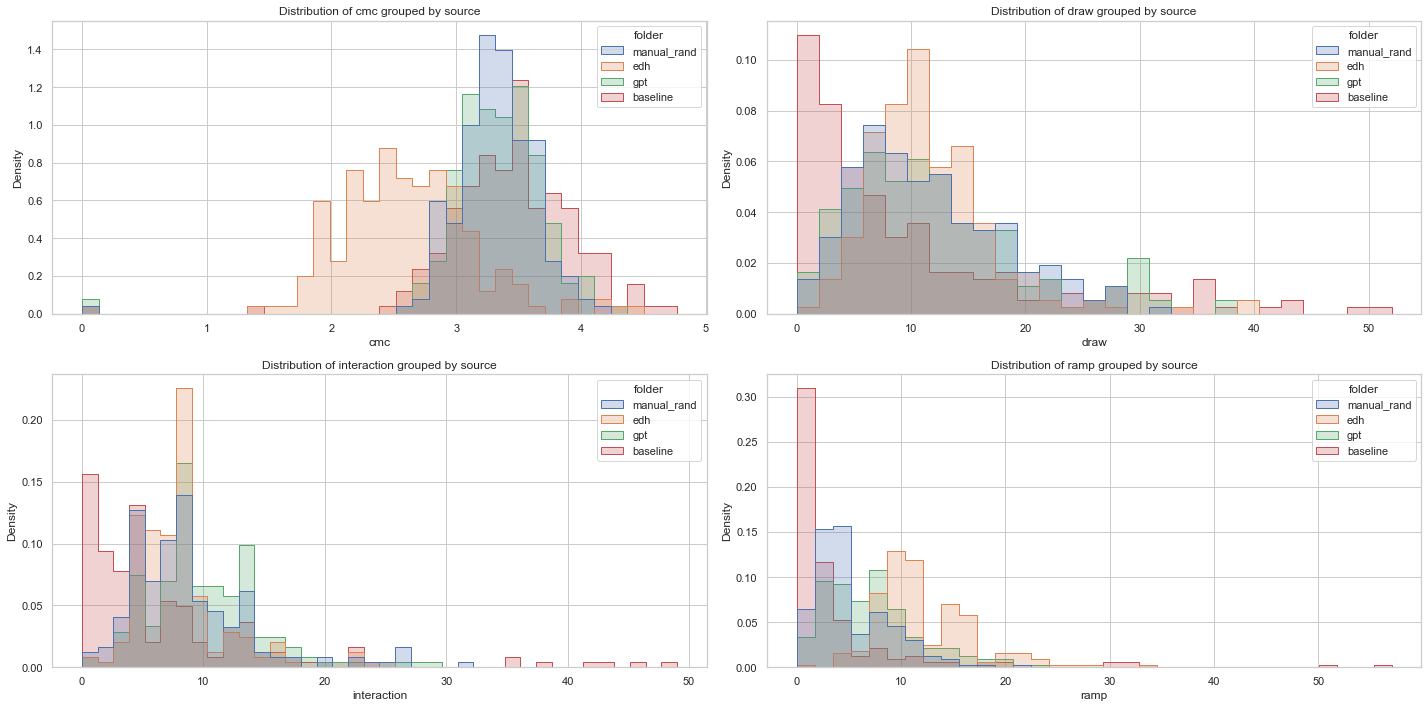

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))

# Create a column list excluding 'folder'
columns = df.columns.difference(['folder', 'overall', 'commander'])

# Plotting
for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=column, hue="folder", element="step", stat="density", common_norm=False)
    plt.title(f'Distribution of {column} grouped by source')

plt.tight_layout()
plt.savefig("../docs/distributions.png")
plt.show()

In [ ]:
df[df['cmc'] == 0]

,overall,cmc,ramp,draw,interaction,folder
149,1,0.0,0,0,0,gpt


In [ ]:
from scipy.stats import f_oneway

for col in df.columns.difference(['folder']):
    # Similar setup as Kruskal-Wallis but for ANOVA
    data = [df[df['folder'] == folder][col] for folder in df['folder'].unique()]

    # Perform ANOVA
    stat, p = f_oneway(*data)

    print(col + ' Statistics= %.3f, p= %.3f' % (stat, p))
    if p > 0.05:
        print('Same means across all groups (fail to reject H0)')
    else:
        print('Different means across some groups (reject H0)')

cmc Statistics= 52.901, p= 0.000
Different means across some groups (reject H0)
draw Statistics= 3.417, p= 0.017
Different means across some groups (reject H0)
interaction Statistics= 2.358, p= 0.071
Same means across all groups (fail to reject H0)
overall Statistics= 162.982, p= 0.000
Different means across some groups (reject H0)
ramp Statistics= 44.858, p= 0.000
Different means across some groups (reject H0)


In [ ]:
df.columns.difference(['baseline'])

Index(['cmc', 'draw', 'folder', 'interaction', 'overall', 'ramp'], dtype='object')

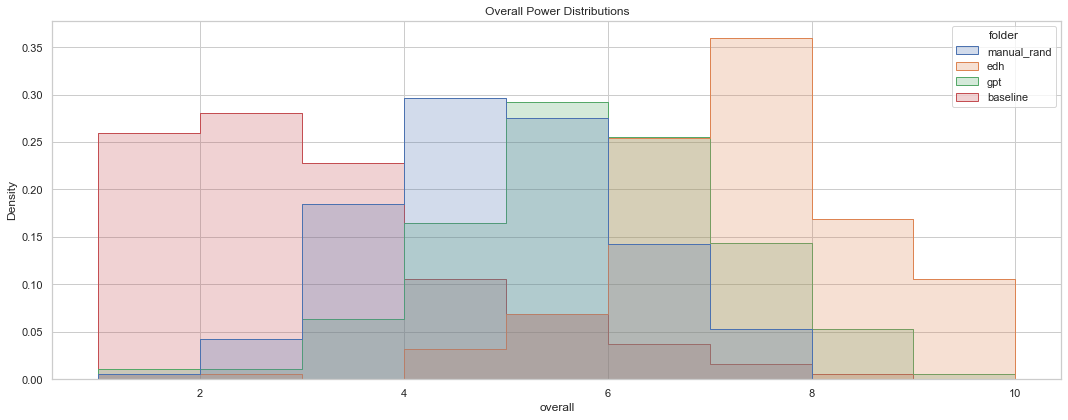

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'overall' is the column of interest
sns.set(style="whitegrid")

# Calculate appropriate bin edges to cover the full range of data without gaps
bin_edges = range(int(df['overall'].min()), int(df['overall'].max()) + 2)  # +2 to ensure the last data point is included

plt.figure(figsize=(15, 6))  # Adjust size as needed
sns.histplot(data=df, x='overall', hue='folder', binwidth=1, bins=bin_edges, stat="density", element="step", common_norm=False)
plt.title('Overall Power Distributions')
plt.tight_layout()
plt.savefig("../docs/power_distributions.png")
plt.show()